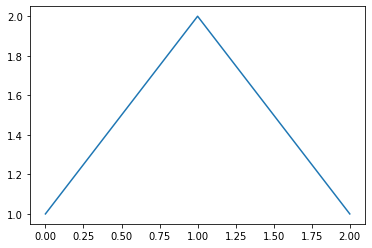

In [1]:
from matplotlib import pyplot as plt
plt.plot([1,2,1])

In [168]:
import time
import torch
import numpy as np
def tensor_to_mps(psi, leg_dim, max_bond_dim, Print=False):
    #leg_dim의 homogeneous 가정함
    a=np.log2(psi.numel()).item()/np.log2(leg_dim).item()
    if a%1 != 0 :
        print('input not valid')
    N = int(a)  # 원래 텐서의 크기
    psi0=psi
    mps_tensors = []
    bond_dim=1
    for n in range(N-1):
        psi = psi.reshape(leg_dim*bond_dim,-1)
        d=bond_dim
        U, S, V, bond_dim = UckSVD(psi,max_bond_dim)
        if n==0:
            mps_tensors.append(U.reshape(1,leg_dim,-1))
        else:
            mps_tensors.append(U.reshape(d,leg_dim,-1))
        psi = torch.matmul(S, V)
    mps_tensors.append(psi.reshape(-1, leg_dim,1))
    #return type : [ (1*leg*leg) (leg*leg*bond) (bond*leg*bond) ..... (bond*leg*1)]
    if Print:
        PrintMPS(mps_tensors)
        result = contract_mps(mps_tensors)
        print('loss of MPS(%) : ',100*torch.sum(torch.abs(result.flatten() - psi0.flatten()))/torch.sum(torch.abs(psi0.flatten())).item())
        print('###############################################')
    return mps_tensors


def contract_mps(mps_tensors):
    #leg_dim의 homogeneous 가정함
    # MPS 텐서 목록이 비어 있으면 에러를 발생시킵니다.
    if len(mps_tensors) == 0:
        raise ValueError("MPS tensor list cannot be empty")
    leg_dim=mps_tensors[0].size(1)
    input_indices = ''.join([chr(ord('a')+j)+chr(ord('A')+j)+chr(ord('a')+j+1)+',' for j in range(len(mps_tensors))])[:-1]
    output_indices = 'a'+''.join([chr(ord('A')+j) for j in range(len(mps_tensors))])+chr(ord('a')+len(mps_tensors))
    #print(input_indices,output_indices)
    result = torch.einsum(f"{input_indices}->{output_indices}", *mps_tensors)
    
    # return type : 1 * (leg_dim) * (leg_dim) *(leg_dim) *......* 1
    return result


def PrintMPS(mps):
    print('###############################################')
    print('printing MPS vector')
    print('###############################################')
    for idx, tensor in enumerate(mps):
        print(f"MPS tensor {idx}: {tensor.shape}")
    print('###############################################')
    
    
def UckSVD(psi,bond_dim = 100):
        max_bond_dim=bond_dim
        U, S, V = torch.linalg.svd(psi, full_matrices=False)
        bond_dim1 = min(S.size(0), max_bond_dim)
        U = U[:, :bond_dim1]
        S = torch.diag(S[:bond_dim1])
        #S=torch.tensor(S, dtype=torch.cfloat)
        V = V[:bond_dim1,:]
        return U, S, V, bond_dim1
    
    
def pauli(n):
    if n==3:
        return torch.tensor([[1, 0], [0, -1]], dtype=torch.cfloat)
    elif n==1:
        return torch.tensor([[0, 1], [1, 0]], dtype=torch.cfloat)
    elif n==2:
        return torch.tensor([[0, -1j], [1j, 0]], dtype=torch.cfloat)
    
def reorder_indices(tensor, k):
    # 입력 텐서의 차원을 확인하고 적절한 입력인지 확인
    assert len(tensor.shape) == 2 * k, f"Input tensor must have rank {2 * k}, but have {len(tensor.shape)}"

    # 인덱스 문자열을 생성
    input_indices = ''.join([chr(ord('a')+j)+chr(ord('A')+j) for j in range(k)])
    output_indices = ''.join([chr(ord('a')+j) for j in range(k)]) + ''.join([chr(ord('A')+j) for j in range(k)])
    #print(input_indices)
    #print(ouput_indices)
    # 인덱스를 재구성하여 텐서를 반환
    reordered_tensor = torch.einsum(f"{input_indices}->{output_indices}", tensor)
    return reordered_tensor

def hopper(d):
    sigma_x = pauli(1)
    sigma_y = pauli(2)
    sigma_z = pauli(3)
    # 초기 행렬을 단위 행렬로 설정
    
    #print(H)
    if d==0:
        return torch.tensor([[0.0, 0.0], [0.0, 1.0]],dtype=torch.cfloat)
    elif d>0:
        H = 0.5 * (sigma_x + 1j * sigma_y)
        for i in range(d-1):
            H = np.tensordot(H, sigma_z,axes=0)
        H=np.tensordot(H, 0.5 * torch.matmul((sigma_x - 1j * sigma_y),sigma_z),axes=0) # 순서 틀렸을수있음
        return reorder_indices(torch.tensor(H, dtype=torch.cfloat),d+1)
    elif d<0:
        d=-d
        H = 0.5 * (sigma_x - 1j * sigma_y)
        for i in range(d-1):
            H = np.tensordot(H, sigma_z,axes=0)
        H=np.tensordot(H, 0.5 * torch.matmul(sigma_z,(sigma_x + 1j * sigma_y)),axes=0) # 순서 틀렸을수있음
        #return : C^t_d C_0 // jordanwigner form i1i2i3...j1j2j3...
        return reorder_indices(torch.tensor(H, dtype=torch.cfloat),d+1)
    
def reduceMPS(psi,d):
    leg=psi[0].shape[1]
    assert len(psi)%d == 0, f"Input MPS must have rank {d}*n, but have {len(psi)}"
    psir=[]
    for i in range(int(len(psi)/d)):
        T=psi[i*d:i*d+d]
        A=contract_mps(T).reshape(psi[i*d].shape[0],leg**d,-1)
        psir.append(A)
    return psir

def Transfer(psi):
    D=psi.shape[0]
    T=torch.einsum("aAb,cAd->bdac",psi.conj(),psi)
    Tt=T.reshape(D*D,-1)
    #print(Tt.shape)
    U,S,V, d=UckSVD(Tt,10)
    return S

def Diag_trunk(hamiltonian, D):
    # 대칭 행렬인지 확인
    #assert torch.allclose(hamiltonian, hamiltonian.conj().T), "Input must be a hermite matrix."
    assert torch.allclose(hamiltonian, hamiltonian.conj().T, atol=1e-5, rtol=1e-3), "Input must be a hermite matrix."
    # 해밀토니안 행렬의 고유값과 고유벡터 계산
    eigenvalues, eigenvectors = torch.linalg.eigh(hamiltonian)
    # 고유값을 오름차순으로 정렬하고 상위 D개만 선택
    sorted_indices = torch.argsort(eigenvalues)
    D=np.min([D,len(eigenvalues)])
    top_d_indices = sorted_indices[:D]

    # 선택한 고유값과 해당 고유벡터 추출
    top_d_eigenvalues = eigenvalues[top_d_indices]
    top_d_eigenvectors = eigenvectors[:, top_d_indices]
    S = torch.diag(top_d_eigenvalues)
    #S=torch.tensor(S, dtype=torch.cfloat)
    return S, top_d_eigenvectors

def zipper_vec( bra_vector, operator, cat_vector):
    # 텐서의 인덱스 문자열 생성
    cat_indices = 'z' +  ''.join([chr(ord('a') + i) for i in range(len(cat_vector.shape)-2)]) +'w'
    bra_indices = 'Z' + ''.join([chr(ord('A') + i) for i in range(len(bra_vector.shape)-2)]) + 'W'
    operator_indices =  ''.join([chr(ord('A') + i) for i in range(len(bra_vector.shape)-2)]) + ''.join([chr(ord('a') + i) for i in range(len(cat_vector.shape)-2)]) #서순에 유의
    # 텐서 계약 수행
    contracted_result = torch.einsum(f"{cat_indices},{operator_indices},{bra_indices}->{'ZWzw'}", cat_vector, operator, bra_vector)#,optimize=True)
    return contracted_result

def mulTD(operators):
    A=1.0
    for i in operators:
        A=np.tensordot(A, i,axes=0)
    return reorder_indices(torch.tensor(A, dtype=torch.cfloat),len(operators))

def zipper_mps(bra_mps, operators, cat_mps, isLong=False):
    if isLong:
        # 텐서의 인덱스 문자열 생성
        result=torch.einsum("aAb,AB,cBd->abcd",bra_mps[0],operators[0],cat_mps[0])
        for i in range(1,len(cat_mps)):
            p=torch.einsum("aAb,AB,cBd->abcd",bra_mps[i],operators[i],cat_mps[i])
            result=torch.einsum("abAB,bcBC->acAC",result,p)
        #"abAB" : ab: bra index, a out, b in // AB : cat index, A in, B out
        return result
    else:
        bra=contract_mps(bra_mps)
        cat=contract_mps(cat_mps)
        operator=mulTD(operators)
        return zipper_vec(bra,operator,cat)
    
def hopper_mps(d):
    sigma_x = pauli(1)
    sigma_y = pauli(2)
    sigma_z = pauli(3)
    operator=[]
    if d==0:
        operator.append( torch.tensor([[0.0, 0.0], [0.0, 1.0]],dtype=torch.cfloat) )
        return operator
    elif d>0:
        operator.append( 0.5 * (sigma_x + 1j * sigma_y) )
        for i in range(d-1):
            operator.append( sigma_z)
        operator.append( 0.5 * torch.matmul((sigma_x - 1j * sigma_y),sigma_z)) # 순서 틀렸을수있음
        return operator
    elif d<0:
        d=-d
        operator.append( 0.5 * (sigma_x - 1j * sigma_y) )
        for i in range(d-1):
            operator.append( sigma_z)
        operator.append( 0.5 * torch.matmul(sigma_z,(sigma_x + 1j * sigma_y))) # 순서 틀렸을수있음
        return operator
    
def densitycorr(d):
    if d==0:
        return [hopper(0)]
    else:
        T=[hopper(0), *([torch.eye(2)]*(abs(d)-1)), hopper(0)]
    return T
    
def Iterative_diag(ham,L,max_dim,dmax):
    #ham as dict, L : site num max_dim : max bond dim dmax: max interaction length
    leg=2
    H=torch.tensor([[0]], dtype=torch.cfloat)
    Eg=[]
    gap=[]
    psi=[]
    bond_dim=1
    for n in range(L):
        #print(n)
        #construction of new H
        H0=torch.einsum("ij,kl->ikjl",H,torch.eye(2)).reshape(bond_dim*leg,-1)
        for key in ham.keys():
            if np.max(key) == n and len(key)==2:
                d=key[1]-key[0]
                #dmax보다 먼 interaction 있나 check
                if np.abs(d)>dmax:
                    print("dmax not proper")
                    return -1
                #T 준비 // use에 따라 이 part만 modify
                T=hopper_mps(d)
                d=np.abs(d)
                #bra,cat 준비
                if d==0:
                    cat_mps=[]
                else:
                    cat_mps=psi[-d:]
                cat_mps.append(torch.eye(bond_dim*2,dtype=torch.cfloat).reshape(bond_dim,leg,-1))
                bra_mps=[]
                for i in cat_mps:
                    bra_mps.append(i.conj())
                #H0에 add
                H0=H0+ham[key]*torch.einsum("abaB->bB",zipper_mps(bra_mps,T,cat_mps))
            elif np.max(key) == n and len(key)==4:
                d=key[2]-key[0]
                #dmax보다 먼 interaction 있나 check
                if np.abs(d)>dmax:
                    print("dmax not proper")
                    return -1
                #T 준비 // use에 따라 이 part만 modify
                T=densitycorr(d)
                #bra,cat 준비
                if d==0:
                    cat_mps=[]
                else:
                    cat_mps=psi[-d:]
                cat_mps.append(torch.eye(bond_dim*2,dtype=torch.cfloat).reshape(bond_dim,leg,-1))
                bra_mps=[]
                for i in cat_mps:
                    bra_mps.append(i.conj())
                #H0에 add    
                H0=H0+ham[key]*torch.einsum("abaB->bB",zipper_mps(bra_mps,T,cat_mps))
        #iterative diagonalization
        S, U = Diag_trunk(H0,max_dim)
        psi.append(U.reshape(bond_dim,leg,-1))
        bond_dim=len(S)
        #if len(psi)>dmax:
            #psi=psi[-dmax:]
        H=S
        gap.append(H[1,1]-H[0,0])
        Eg.append(H[0,0])
    return H, np.real(Eg), np.real(gap),psi

def Iterative_diag_mpo(ham_mpo,max_dim,start_ind,end_ind):
    #ham as dict, L : site num max_dim : max bond dim dmax: max interaction length
    leg=ham_mpo[0].shape[0]
    H=ham_mpo[0][:,:,start_ind,:]
    Eg=[]
    gap=[]
    psi=[]
    bond_dim=1
    for i,ham in enumerate(ham_mpo):
        print(i)
        #construction of new H
        if i>0:
            H0=torch.einsum("ija,klab->ikjlb",H,ham)[:,:,:,:,end_ind].reshape(bond_dim*leg,-1)
        elif i==0:
            H0=H[:,:,end_ind]
        #iterative diagonalization
        S, U = Diag_trunk(H0,max_dim)
        psi0=U.reshape(bond_dim,leg,-1)
        psi.append(psi0)
        bond_dim=len(S)
        H=torch.einsum("ija,klab,ikA,jlB->ABb",H,ham,psi0.conj(),psi0)
        H=(H+torch.einsum("ija->jia",H.conj()))/2
        gap.append(H[1,1]-H[0,0])
        Eg.append(H[0,0])
    return H, np.real(Eg), np.real(gap),psi

def Ntot(psi):
    T=torch.tensor([[0,0],[0,1]],dtype=torch.cfloat)

    for i in range(0,len(psi)):
        T=torch.einsum("aAb,ai,iAB->bB",psi[i].conj(),T,psi[i])+torch.einsum("abaB->bB",zipper_vec(psi[i].conj(),hopper(0),psi[i]))
    return np.real(T[0,0])

def Nodd(psi):
    T=-torch.tensor([[0,0],[0,0]],dtype=torch.cfloat)
    for i in range(0,len(psi)):
        T=torch.einsum("aAb,ai,iAB->bB",psi[i].conj(),T,psi[i])+(-1)**i*torch.einsum("abaB->bB",zipper_vec(psi[i].conj(),hopper(0),psi[i]))
    return np.real(T[0,0])

def hubard(t,lam,L):
    ham = {}  # 딕셔너리 초기화
    for j in range(L):
        i=2*j
        ham[(i, i+2)] = t*torch.tensor(1.0)
        ham[(i+2, i)] = t*torch.tensor(1.0)
        ham[(i+1, i+3)] = t*torch.tensor(1.0)
        ham[(i+3, i+1)] = t*torch.tensor(1.0)
        ham[(i,i)]= -lam/2* torch.tensor(1.0+0.0*1j)
        ham[(i+1,i+1)]= -lam/2* torch.tensor(1.0+0.0*1j)
        ham[(i,i,i+1,i+1)] = lam*torch.tensor(1.0)
    return ham

def Spin_site():
    #up, down spin 가능한 electron site의 spin operator, 3*2*2*2*2 form
    S=torch.stack([hopper(1)+hopper(-1),-1j*hopper(1)+1j*hopper(-1),mulTD([hopper(0),torch.eye(2)])-mulTD([torch.eye(2),hopper(0)])],dim=0)/2
    return S

def N_site():
    #up, down spin 가능한 electron site의 electron total number operator, 2*2*2*2 form
    return mulTD([hopper(0),torch.eye(2)])+mulTD([torch.eye(2),hopper(0)])

def Spin_operator(j):
    dim = int(2 * j + 1)
    
    # 각운동량 연산자 Jx, Jy, Jz를 초기화합니다.
    Jx = np.zeros((dim, dim), dtype=np.complex128)
    Jy = np.zeros((dim, dim), dtype=np.complex128)
    Jz = np.zeros((dim, dim), dtype=np.complex128)

    # Jx, Jy, Jz 행렬을 채웁니다.
    for m1 in range(-j, j+1):
        for m2 in range(-j, j+1):
            if m1 == m2 + 1:
                Jx[(j+m1), (j+m2)] = 0.5 * np.sqrt((j+m1) * (j-m1+1))
                Jy[(j+m1), (j+m2)] = -0.5j * np.sqrt((j+m1) * (j-m1+1))
            if m1 == m2 - 1:
                Jx[(j+m1), (j+m2)] = 0.5 * np.sqrt((j-m1) * (j+m1+1))
                Jy[(j+m1), (j+m2)] = 0.5j * np.sqrt((j-m1) * (j+m1+1))
            if m1 == m2:
                Jz[(j+m1), (j+m2)] = m1

    return torch.tensor([Jx, Jy, Jz],dtype=torch.cfloat)

def Totalsum(T):
    dim=T.shape[0]
    t1=torch.stack([torch.eye(dim),0*torch.eye(dim)],dim=0)
    t2=torch.stack([T,torch.eye(dim)],dim=0)
    return torch.einsum("abcd->cdab",torch.stack([t1,t2],dim=0))
def evaluate_mpo(psi,T):
    H=[]
    for i in range(len(psi)):
        if i==0:
            H=torch.einsum("klab,ikA,ilB->ABab",T[i],psi[i].conj(),psi[i])
        else:
            H=torch.einsum("ijca,klab,ikA,jlB->ABcb",H,T[i],psi[i].conj(),psi[i])
    return H[0,0,:,:]


In [3]:
#### mps 만들기 test

# 양자 상태 벡터 생성 (예: 크기가 2^4인 무작위 복소수 벡터)
psi = torch.rand(3**4) + 1j * torch.rand(3**4)

# 양자 상태 벡터를 MPS로 변환
mps_tensors = tensor_to_mps(psi, 3, max_bond_dim=5,Print=True)

# MPS 텐서 출력
#PrintMPS(mps_tensors)


# 예시 MPS 텐서 목록
mps_tensors = [
    torch.tensor([[[1, 2], [3, 4]]], dtype=torch.float32),
    torch.tensor([[[5, 6], [7, 8]]], dtype=torch.float32),
    torch.tensor([[[9, 10], [11, 12]]], dtype=torch.float32)
]

# MPS 텐서들을 contract합니다.
#result = contract_mps(tensor_to_mps(psi, 3, max_bond_dim=5,Print=True))
#print('loss of MPS')
#print(torch.sum(torch.abs(result.flatten() - psi.flatten()))/torch.sum(torch.abs(psi.flatten())))

###############################################
printing MPS vector
###############################################
MPS tensor 0: torch.Size([1, 3, 3])
MPS tensor 1: torch.Size([3, 3, 5])
MPS tensor 2: torch.Size([5, 3, 3])
MPS tensor 3: torch.Size([3, 3, 1])
###############################################
loss of MPS(%) :  tensor(13.1524)
###############################################


C:\Users\kimsm\AppData\Local\Temp/ipykernel_17192/1982814478.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S=torch.tensor(S, dtype=torch.cfloat)


[ -1.65      -1.65      -3.579378  -4.242778  -6.049818  -6.352711
  -8.246932  -8.814154 -10.628471 -10.951388 -12.772869 -13.268013
 -15.031323 -15.340945 -17.156775 -17.580034 -19.306313 -19.765345
 -21.586443 -21.986046 -23.725239 -24.119728 -25.90852  -26.335041
 -28.078362 -28.459223 -30.254313 -30.71612  -32.451397 -32.858536
 -34.64314  -35.060966 -36.801926 -37.233837 -39.01178  -39.419594
 -41.158813 -41.600094 -43.377163 -43.754375 -45.49028  -45.970333
 -47.741833 -48.090538 -49.81609  -50.34192  -52.104782 -52.42964
 -54.182487 -54.717377 -56.48189  -56.789192 -58.55784  -59.0829
 -60.848057 -61.158833 -62.931175 -63.454865 -65.21816  -65.52369
 -67.31957  -67.83069  -69.589584 -69.908226 -71.70789  -72.20913
 -73.9704   -74.298546 -76.093925 -76.58356  -78.35249  -78.68299
 -80.47115  -80.95109  -82.72682  -83.06847  -84.85923  -85.31866
 -87.052666 -87.46072 ]
tensor(41.0001)
tensor(0.1567)


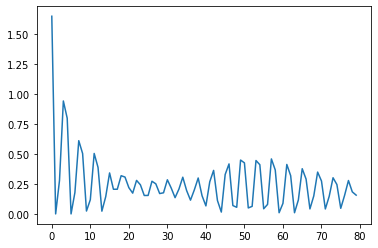

In [75]:
#iterative diag test

ham = {}  # 딕셔너리 초기화
L=40
lam=3.3
h=torch.rand(L)
for j in range(L):
    i=2*j
    ham[(i, i+2)] = 1*torch.tensor(1.0)
    ham[(i+2, i)] = 1*torch.tensor(1.0)
    ham[(i+1, i+3)] = 1*torch.tensor(1.0)
    ham[(i+3, i+1)] = 1*torch.tensor(1.0)
    ham[(i,i)]= -lam/2* torch.tensor(1.0+0.0*1j)
    ham[(i+1,i+1)]= -lam/2* torch.tensor(1.0+0.0*1j)
    ham[(i,i,i+1,i+1)] = lam*torch.tensor(1.0)
H,Eg,gap,psi=Iterative_diag(ham,2*L,70,2)

#PrintMPS(psi)
plt.plot(range(2*L),gap)
print(np.array(Eg))
print(Ntot(psi))
print(H[1,1]-H[0,0])

[  0.         -1.         -1.4142135  -2.2360673  -2.7320514  -3.4939575
  -4.027338   -4.7587624  -5.313527   -6.026357   -6.594716   -7.2934804
  -7.868685   -8.557365   -9.138067   -9.818921  -10.403014  -11.077674
 -11.663784  -12.33389   -12.921566  -13.588355  -14.177224  -14.841528
 -15.431179  -16.093588  -16.683754  -17.344675  -17.93529   -18.594893 ]


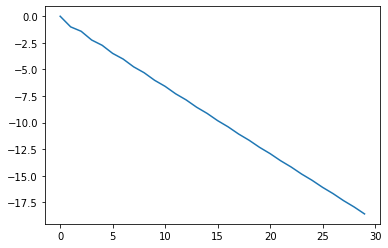

In [79]:
#iterative diag test
ham = {}  # 딕셔너리 초기화
L=30
h=torch.rand(L)
for i in range(L):
    ham[(i, i+1)] = 1*torch.tensor(1.0)#/2**i
    ham[(i,i)]= 0.00 * torch.tensor(1.0+0.0*1j)
    ham[(i+1, i)] = 1*torch.tensor(1.0)#/2**i

H,Eg,gap,psi=Iterative_diag(ham,L,60,1)
print(np.array(Eg))
plt.plot(np.array(Eg))
#plt.plot(-np.ones(L)*2/np.pi)
#plt.plot([2*f for f in np.array(range(int(L/2)))],[-2*np.sum([np.cos(i*np.pi/(2*(k+1))) for i in range(1,k+1)])/(2*k+1) for k in np.array(range(int(L/2)))])

In [5]:
L=30
eg=[]
gap=[]
Nt=[]
Lam=np.arange(-2,2,0.1)
for lam in Lam:
    ham=hubard(1,lam,L)
    H,Eg,gap1,psi=Iterative_diag(ham,2*L,30,2)
    eg.append(Eg[-1])
    gap.append(gap1[-1])
    Nt.append(Ntot(psi))
plt.plot(Lam,gap)

#plt.plot(range(L),Eg)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

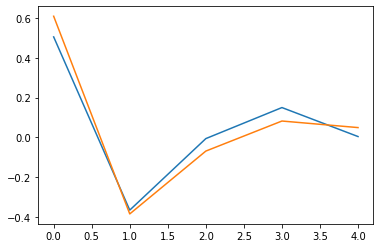

In [92]:
# correlation function
L=30
H,eg,gap,psi=Iterative_diag(hubard(1,0,L),2*L,50,2)
Q1=[torch.einsum("zxzX->xX",zipper_mps([i.conj() for i in psi[-np.abs(n*2)-1:]],hopper_mps(2*n),psi[-np.abs(n*2)-1:]))[0,0] for n in range(0,5)]
H,eg,gap,psi=Iterative_diag(hubard(1,2,L),2*L,50,2)
Q2=[torch.einsum("zxzX->xX",zipper_mps([i.conj() for i in psi[-np.abs(n*2)-1:]],hopper_mps(2*n),psi[-np.abs(n*2)-1:]))[0,0] for n in range(0,5)]

plt.plot(Q1)
plt.plot(Q2)
#print(Ntot(psi))
#print(Nodd(psi))

In [175]:
h1=torch.stack([torch.eye(3),0*torch.eye(3),0*torch.eye(3)],dim=0)
h2=torch.stack([Spin_operator(1)[2],0*torch.eye(3),0*torch.eye(3)],dim=0)
h3=torch.stack([Spin_operator(1)[0]*2,-Spin_operator(1)[2]*2,torch.eye(3)],dim=0)
h=torch.stack([h1,h2,h3],dim=0)
h=torch.einsum("abij->ijab",h)
print(h.shape)
H,eg,gap,psi=Iterative_diag_mpo([h]*30,30,2,0)
s=zipper_mps([i.conj() for i in psi], [Spin_operator(1)[2]]*30, psi, isLong=True)
print(s[0,1,0,1])
print(evaluate_mpo(psi,[Totalsum(Spin_operator(1)[2])]*30)[1,0])

torch.Size([3, 3, 3, 3])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
tensor(0.0041+0.j)
tensor(20.8762+0.j)


In [123]:
h1=torch.stack([torch.eye(3),0*torch.eye(3),0*torch.eye(3),0*torch.eye(3),0*torch.eye(3)],dim=0)
h2=torch.stack([Spin_operator(1)[2],0*torch.eye(3),0*torch.eye(3),0*torch.eye(3),0*torch.eye(3)],dim=0)
h3=torch.stack([Spin_operator(1)[1],0*torch.eye(3),0*torch.eye(3),0*torch.eye(3),0*torch.eye(3)],dim=0)
h4=torch.stack([Spin_operator(1)[0],0*torch.eye(3),0*torch.eye(3),0*torch.eye(3),0*torch.eye(3)],dim=0)
h5=torch.stack([Spin_operator(1)[2]*1,Spin_operator(1)[0]*2,Spin_operator(1)[1]*2, Spin_operator(1)[2]*2,torch.eye(3)],dim=0)
h=torch.stack([h1,h2,h3,h4,h5],dim=0)
print(h.shape)


torch.Size([5, 5, 3, 3])
